##  read inputs, handle missing values, scale input/output, convert to float32

In [1]:
from faceKeySrc import load_data, shared_dataset, plot_train_valid
from deprecated import linear_regresion,train_early_stopping
import theano.tensor as T
import theano
import numpy

In [2]:
FTRAIN = '../data/training.csv'
FTEST = '../data/test.csv'
X, Y = load_data(FTRAIN)

just drop all the samples with missing values, consider a better approach


This implementation is based on Lisa-lab's tutorial on theano

### write a multi-target linear regression

In [3]:
# generate train and validation sets
from sklearn.cross_validation import train_test_split
train_set_x, valid_set_x, train_set_y, valid_set_y = train_test_split(
    X, Y, test_size=0.3, random_state=42
)
train_set_x, train_set_y = shared_dataset(train_set_x, train_set_y)
valid_set_x, valid_set_y = shared_dataset(valid_set_x, valid_set_y)

### sgd optimization

In [7]:
def sgd_linear_reg_multi_target_earlyStop(train_set_x, train_set_y,
                                          valid_set_x, valid_set_y,
                                          learning_rate=0.01,
                                          n_epochs=1000,
                                          batch_size=10,
                                          patience = 500,  # look as this many examples regardless,
                                          improvement_threshold = 0.995,  # a relative improvement of this much is
                                                        # considered significant
                                          patience_increase = 2,  # wait this much longer when a new best is
                                         ):
    
    #compute the number of mini batches
    n_train_batches= train_set_x.get_value(borrow=True).shape[0] // batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
    print('...building the model')
    
    # allocate symbolic variable for data
    index = T.lscalar()
    
    # generate symbolic variable for data - x, y represent a single batch
    x= T.matrix('x')
    y=T.matrix('y')
    
    # construct the regressor
    linear_regressor = linear_regresion(input=x , n_in= 96 * 96, n_out=30)
    
    # compile a theano function to report the validation cost
    validate_model = theano.function(
        inputs=[index],
        outputs=linear_regressor.loss_MSE(y),
        givens={
            x: valid_set_x[index * batch_size: (index + 1) * batch_size],
            y: valid_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    
    # the cost we minimise is MSE
    cost = linear_regressor.loss_MSE(y)
    # compute the gradient of cost
    g_W = T.grad(cost=cost, wrt= linear_regressor.W)
    g_b = T.grad(cost=cost, wrt= linear_regressor.b)
    
    # how to update parameters of the model
    updates=[(linear_regressor.W, linear_regressor.W - learning_rate * g_W),
             (linear_regressor.b, linear_regressor.b - learning_rate * g_b)]
    
    # compile a theano function that concurrently returns the cost
    # and updates the model based on the update rules in updates
    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    
    #train with early stopping
    history_train_loss, history_validation_loss=train_early_stopping(train_model=train_model,
                                                                     validate_model=validate_model,
                                                                     n_epochs=n_epochs,
                                                                     n_train_batches=n_train_batches,
                                                                     n_valid_batches=n_valid_batches,
                                                                     patience = patience,
                                                                     improvement_threshold = improvement_threshold, 
                                                                     patience_increase = patience_increase
                                                                    )
    return history_train_loss, history_validation_loss



In [15]:
history_train_loss, history_validation_loss=sgd_linear_reg_multi_target_earlyStop(train_set_x, train_set_y,
                                                                                  valid_set_x, valid_set_y,
                                                                                  learning_rate=0.005,
                                                                                  n_epochs=3000,
                                                                                  batch_size=16,
                                                                                  patience = 500, 
                                                                                  improvement_threshold = 0.999,
                                                                                  patience_increase = 2, 
                                                                                 )

...building the model


### plot train valid curves

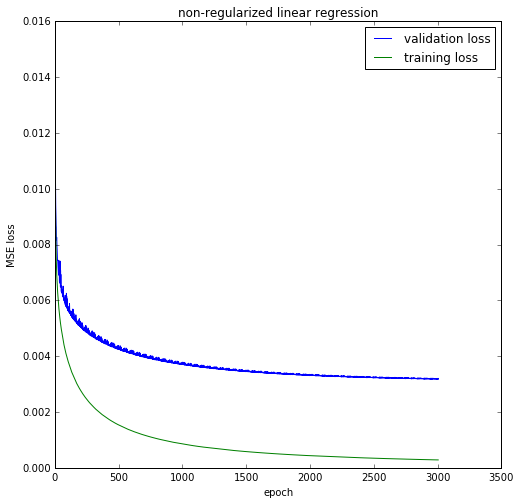

In [16]:
%matplotlib inline
plot_train_valid(history_train_loss=history_train_loss,
                 history_validation_loss=history_validation_loss)